<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/Final-VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

In [2]:
!pip install keras_applications

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [6]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [12]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

print(vgg_notop.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 197, 197, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 49, 49, 128)     

In [7]:
! cp '/content/drive/MyDrive/Kaggle/facesdataset/face-expression-recognition-dataset.zip' '/tmp'

In [8]:
import zipfile
zip_ref = zipfile.ZipFile("/tmp/face-expression-recognition-dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [8]:
trainPath='/tmp/images/images/train'
valPath='/tmp/images/images/validation'

In [ ]:
# ! rm -rf train; mkdir train
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/emotion.zip' -d train
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/facesdb.zip' -d train
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/train.zip' -d train
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/googlesearch.zip' -d train
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/googleset.zip' -d train
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/jaffe.zip' -d train
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/umea.zip' -d train

In [ ]:
# ! rm -rf dev; mkdir dev
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-public.zip' -d dev
# ! rm -rf test; mkdir test
# ! unzip -q '/content/drive/My Drive/cs230 project/dataset/fer2013/test-private.zip' -d test

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
# train_generator  = get_datagen('/content/train', True)
# dev_generator    = get_datagen('/content/dev')
# test_generator  = get_datagen('/content/test')

In [10]:
train_generator  = get_datagen(trainPath, True)
dev_generator    = get_datagen(valPath)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
# from sklearn.utils import class_weight
# file_stream = file_io.FileIO('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv', mode='r')
# data = pd.read_csv(file_stream)
# data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
# X, Y = data[' pixels'].tolist(), data['emotion'].values
# class_weights = class_weight.compute_class_weight('balanced',
#                                                     np.unique(Y),
#                                                     Y)


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=100,
    callbacks=[rlrop],
    #use_multiprocessing=True,
) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
224/224 [==============================] - 261s 1s/step - loss: 1.6279 - accuracy: 0.3640 - val_loss: 1.1073 - val_accuracy: 0.5911
Epoch 2/100
224/224 [==============================] - 256s 1s/step - loss: 1.2122 - accuracy: 0.5520 - val_loss: 1.0826 - val_accuracy: 0.6091
Epoch 3/100
  6/224 [..............................] - ETA: 4:03 - loss: 1.1191 - accuracy: 0.5656

In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.9100893073611789, 0.6863425925925926]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.8456436241114581, 0.7022569444444444]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


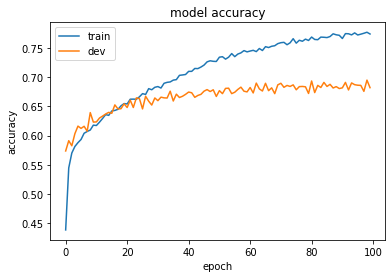

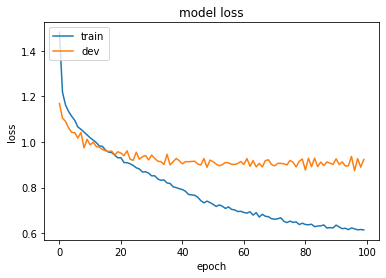

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/cs230 project/models/' + 'VGG16' + epoch_str + test_acc + '.h5')